# Práctica 5 : Regresión lineal regularizada, sesgo y varianza

In [359]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
import scipy.optimize as opt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler, MinMaxScaler

## Regresión Lineal Regularizada

In [359]:
#########
# MUY IMPORTANTE HACER RAVEL PARA PASAR DE (12,) a (12). SI USAS (12,) HACE BROADCASTING
########

def cargaDatos(file = 'ex5data1.mat'):
    m = loadmat(file)
    x_train = m['X']
    y_train = m['y'].ravel()
    x_test = m['Xtest']
    y_test = m['ytest'].ravel()
    x_val = m['Xval']
    y_val = m['yval'].ravel()
    train = [x_train, y_train]
    test = [x_test, y_test]
    val = [x_val, y_val]
    return train, test, val

In [378]:
def coste_reg(T, X, Y, Lambda):
    coef1 = (1/(2* X.shape[0]))
    
    H = np.dot(X,T)
    D = H - Y
    sumErs = np.sum(D**2)
    
    coef2 = (Lambda/(2*X.shape[0]))
    reg = (T[1:]**2).sum()
    
    coste = ( coef1 * sumErs ) + ( coef2 * reg )
    return coste

In [539]:
def gradiente_reg(T, X, Y, Lambda):
    H = np.dot(X,T)
    D = H - Y
    G = np.dot(X.T, D)
    G = G / X.shape[0]
    G[1:] += (T[1:] * (Lambda / X.shape[0]))
    return G

In [534]:
def main1():
    tr, te, vl = cargaDatos()
    X = tr[0]
    Y = tr[1].ravel()
    m = X.shape[0]
    X = np.hstack([np.ones( [m, 1 ] ) , X ] )
    T = np.ones((X.shape[1],))
    grad = gradiente_reg(T,X,Y,1)
    c = coste_reg(T,X,Y,1)
    print(c)
    print(grad)

In [540]:
main1()

303.9931922202643
[-15.30301567 598.25074417]


In [382]:
def costeygradienteReg(Theta,X,Y,Lambda):

    Xaux = np.hstack([np.ones((X.shape[0], 1)), X])
    coste = coste_reg(Theta,Xaux,Y,Lambda)
    gradiente = gradiente_reg(Theta,Xaux,Y,Lambda)
    return coste,gradiente

In [427]:
def optimizar(X,Y,Lambda):
    T = np.ones((X.shape[1]+1,1))
    result = opt.minimize(costeygradienteReg,T,args=(X,Y,Lambda),method='TNC',jac=True)['x']
    return result

In [384]:
def main2():
    tr, te, vl = cargaDatos()
    X = tr[0]
    Y = tr[1]
    r = optimizar(X,Y,0)
    print(r)

In [385]:
main2()

[13.08790348  0.36777923]


In [386]:
def pintarDatos():
    tr, te, vl = cargaDatos()
    X = tr[0]
    Y = tr[1]
    r = optimizar(X,Y,0)
    
    plt.figure()
    plt.plot(X,Y,"x")
    min_x = min(X)
    max_x = max(X)
    min_y = r[0] + r[1] * min_x
    max_y = r[0] + r[1] * max_x
    plt.plot([min_x, max_x], [min_y, max_y])
    plt.savefig("resultado.pdf")

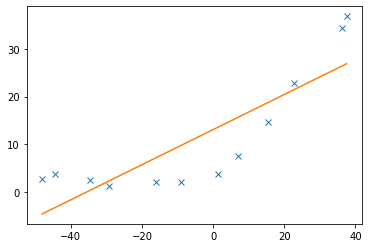

In [387]:
pintarDatos()

## Curvas de Aprendizaje

In [441]:
def costeygradienteReg2(Theta,X,Y,Lambda):
    coste = coste_reg(Theta,X,Y,Lambda)
    gradiente = gradiente_reg(Theta,X,Y,Lambda)
    return coste,gradiente

In [442]:
def optimizar2(X,Y,Lambda):
    T = np.ones((X.shape[1],)).ravel()
    result = opt.minimize(costeygradienteReg2,T,args=(X,Y,Lambda),method='TNC',jac=True)['x']
    return result

In [443]:
def curvaAprendizaje():
    tr,te,vl = cargaDatos()
    X = tr[0]
    Y = tr[1]
    
    Xval = vl[0]
    Xval = np.hstack([np.ones((Xval.shape[0], 1)), Xval])
    Yval = vl[1]
    
    erroresT = np.zeros((X.shape[0],))
    erroresV = np.zeros((X.shape[0],))
    ejeX = np.zeros((X.shape[0],))
    for j in range(1,X.shape[0]):
        ejeX[j] = j
        Xaux = X[0:j]
        Yaux = Y[0:j]
        Xaux = np.hstack([np.ones((j, 1)), Xaux])
        r = optimizar2(Xaux,Yaux,0)
        
        erroresT[j] += coste_reg(r,Xaux,Yaux,0)
        erroresV[j] += coste_reg(r,Xval,Yval,0)
    
    plt.figure()
    plt.plot(ejeX[1:], erroresT[1:], 'b', label = "Entrenamiento")
    plt.plot(ejeX[1:], erroresV[1:], 'r', label = "Validacion")
    plt.xlabel("Numero de ejemplos de entrenamiento")
    plt.ylabel("Error")
    plt.legend(loc = 0)
    plt.show()

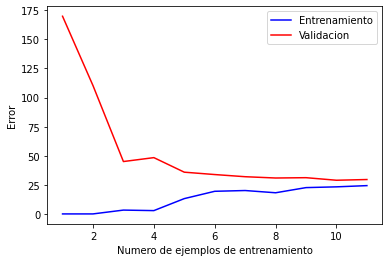

In [444]:
curvaAprendizaje()

## Regresion Polinomial

In [392]:
def generaPolinomio(X,g):
    p = PolynomialFeatures(g)
    X2 = p.fit_transform(X)
    return X2

In [393]:
def normalizar(X):
    mu = np.mean(X, axis=0)
    sigma = np.std(X, axis=0)
    X_norm = (X-mu)/sigma
    return(X_norm, mu, sigma)

In [394]:
def main3():
    tr,te,vl = cargaDatos()
    X = tr[0]
    Y = tr[1]
    Xpol = generaPolinomio(X,8)
    Xpoln , mu, sigma = normalizar(Xpol[:, 1:])
    ones = np.ones((Xpoln.shape[0],1))
    Xpoln = np.hstack([ones, Xpoln])
    
    T = optimizar2(Xpoln, Y, 0)
    
    Xvalues = np.arange(X.min()-5 , X.max()+5, 0.05)
    # Para pasar de 1D array a 2D array. Lo hago porque salia un error que me decía que lo hiciera
    Xvalues = Xvalues.reshape(-1, 1)
    Xpolvalues = generaPolinomio(Xvalues,8)
    Xpolnvalues = (Xpolvalues[:,1:] - mu) / sigma
    ones2 = np.ones((Xpolnvalues.shape[0], 1))
    Xpolnvalues = np.hstack([ones2, Xpolnvalues])
    
    Ypolvalues  = np.dot(Xpolnvalues,T)
    
    ax=plt.gca()
    ax.axis([X.min()-5,X.max()+5,Y.min()-10,Y.max()+5])
    plt.plot(X,Y, "x", color = 'red')
    plt.plot(Xvalues, Ypolvalues, '-b')

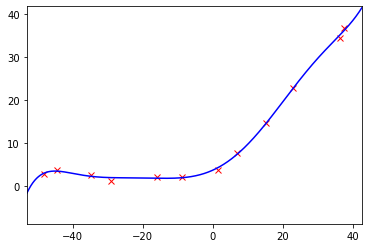

In [395]:
main3()

In [396]:
def normalizar2(X):
    scaler = StandardScaler()
    scaler.fit(X)
    mu = scaler.mean_
    sigma = scaler.scale_
    Y = scaler.transform(X)
    return Y,mu,sigma

In [397]:
def main4():
    tr,te,vl = cargaDatos()
    X = tr[0]
    Y = tr[1]
    Xpol = generaPolinomio(X,8)
    Xpoln , mu, sigma = normalizar2(Xpol[:, 1:])
    ones = np.ones((Xpoln.shape[0],1))
    Xpoln = np.hstack([ones, Xpoln])
    
    T = optimizar2(Xpoln, Y, 0)
    
    Xvalues = np.arange(X.min()-5 , X.max()+5, 0.05)
    # Para pasar de 1D array a 2D array. Lo hago porque salia un error que me decía que lo hiciera
    Xvalues = Xvalues.reshape(-1, 1)
    Xpolvalues = generaPolinomio(Xvalues,8)
    Xpolnvalues = (Xpolvalues[:,1:] - mu) / sigma
    ones2 = np.ones((Xpolnvalues.shape[0], 1))
    Xpolnvalues = np.hstack([ones2, Xpolnvalues])
    
    Ypolvalues  = np.dot(Xpolnvalues,T)
    
    ax=plt.gca()
    ax.axis([X.min()-5,X.max()+5,Y.min()-10,Y.max()+5])
    plt.plot(X,Y, "x", color = 'red')
    plt.plot(Xvalues, Ypolvalues, '-b')

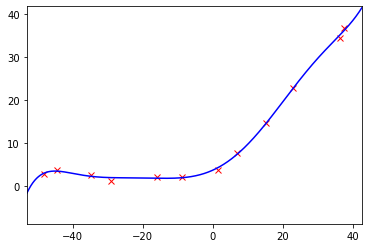

In [399]:
main4()

## Curvas de Aprendizaje

In [400]:
def generaPolinomio(X,g):
    p = PolynomialFeatures(g)
    X2 = p.fit_transform(X)
    return X2

In [515]:
def curvaAprendizaje2(Lambda):
    tr, test, val = cargaDatos()
    
    X = tr[0]
    Y = tr[1]
    
    Xval = val[0]
    Yval = val[1]
    
    print(X.shape)
    print(Xval.shape)
    
    X = generaPolinomio(X,8)
    X,mu,sigma = normalizar(X[:,1:])
    ones = np.ones((X.shape[0],1))
    X = np.hstack([ones,X])
    
    Xval = generaPolinomio(Xval,8)
    Xval = (Xval[:,1:]-mu)/sigma
    ones2 = np.ones((Xval.shape[0],1))
    Xval = np.hstack([ones2,Xval])
    
    ejeX = np.arange(1, X.shape[0], 1)
    errorT = np.zeros(X.shape[0]-1)
    errorV = np.zeros(X.shape[0]-1)
    
    for j in range(1, X.shape[0]):
        X2 = X[0:j, :]
        Y2 = Y[0:j]
        
        r = optimizar2(X2,Y2,Lambda)
        errorT[j-1] = coste_reg(r,X2,Y2,Lambda)
        errorV[j-1] = coste_reg(r,Xval,Yval,Lambda)
    
    plt.plot(ejeX,errorT, 'b' , label = "Entrenamiento")
    plt.plot(ejeX,errorV, 'r' , label = "Validacion")

(12, 1)
(21, 1)


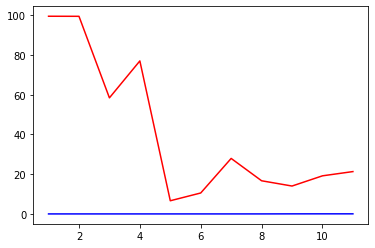

In [516]:
curvaAprendizaje2(0)

(12, 1)
(21, 1)


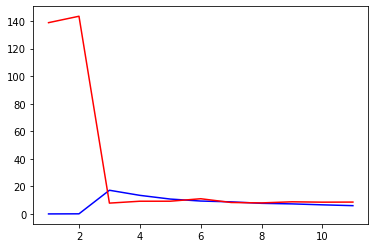

In [519]:
curvaAprendizaje2(1)

(12, 1)
(21, 1)


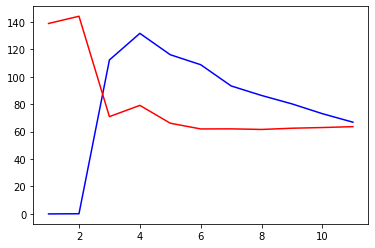

In [520]:
curvaAprendizaje2(100)

## Selección del Parámetro λ

In [530]:
def pruebaLambdas(Lambdas):
    tr, test, val = cargaDatos()
    
    X = tr[0]
    Y = tr[1]
    
    Xval = val[0]
    Yval = val[1]
    
    print(X.shape)
    print(Xval.shape)
    
    X = generaPolinomio(X,8)
    X,mu,sigma = normalizar(X[:,1:])
    ones = np.ones((X.shape[0],1))
    X = np.hstack([ones,X])
    
    Xval = generaPolinomio(Xval,8)
    Xval = (Xval[:,1:]-mu)/sigma
    ones2 = np.ones((Xval.shape[0],1))
    Xval = np.hstack([ones2,Xval])
    
    errorT = np.zeros(Lambdas.shape[0])
    errorV = np.zeros(Lambdas.shape[0])
    
    for j in range(Lambdas.shape[0]):
        
        r = optimizar2(X,Y,Lambdas[j])
        errorT[j] = coste_reg(r,X,Y,Lambdas[j])
        errorV[j] = coste_reg(r,Xval,Yval,Lambdas[j])
        
    return errorT, errorV

In [531]:
def graficarErrorLambdas():
    Lambdas = np.array([0,0.001,0.003,0.01,0.03,0.1,0.3,1,3,10])
    errorT, errorV = pruebaLambdas(Lambdas)
    plt.plot(Lambdas, errorT, 'b', label = 'Entrenamiento')
    plt.plot(Lambdas, errorV, 'r', label = 'Validacion')

(12, 1)
(21, 1)


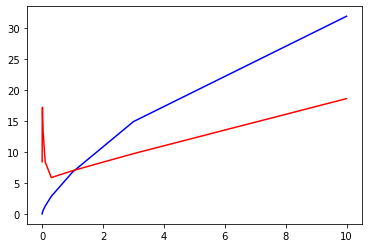

In [532]:
graficarErrorLambdas()